# Introduction to DataJoint

[DataJoint](https://datajoint.org/) is a free, open-source framework for programming scientific databases and computational data pipelines. 

```
pip install datajoint
```

In [1]:
import datajoint as dj

dj.config['database.host'] = 'functional-em.crjvviai1xxh.us-west-2.rds.amazonaws.com'
dj.config['database.user'] = 'read_only'
dj.config['database.password'] = 'secret'
dj.config['database.database']='test_user_db'

## Access the schema and helper modules

This notebook assumes you have access to a copy of the SQL database that houses the functional data and the functional data schema repository. Set-up instructions and technical documentation are [here](https://www.microns-explorer.org/cortical-mm3#f-data).

This notebook will go over how to use DataJoint to access the functional data and the contents of the schema. For an overview of how to use CAVE to access the connectomics data, see [here](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/SynapseAndAnnotationQuery.ipynb).

In [2]:
%%capture
from phase3 import nda, func, utils

## ERD

[ERD](https://docs.datajoint.io/python/definition/11-ERD.html) stands for entity relationship diagram. Tables are depicted as nodes and dependencies as directed edges between them.

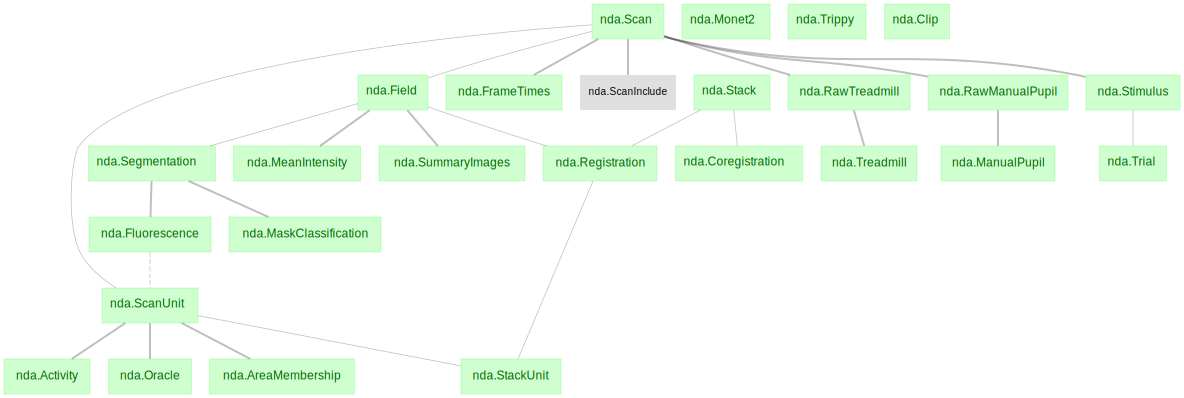

In [3]:
dj.ERD(nda) # View schema ERD

## Basic DataJoint tutorial and data introduction

This tutorial will focus on basic DataJoint usage and introduce the functional data in the schema. 

For detailed information on the contents of the schema, please find our technical documentation [here](https://www.microns-explorer.org/cortical-mm3#f-data). 



### Scan table

Information from the completed scans are located in `nda.Scan`. Access the table by calling:

In [4]:
nda.Scan()

*session    *scan_idx    nframes     nfields     fps       
+---------+ +----------+ +---------+ +---------+ +--------+
4           7            40000       8           6.3009    
4           9            35112       8           6.3009    
4           10           40000       8           6.3009    
5           3            40000       8           6.3009    
5           6            40000       8           6.3009    
5           7            40000       8           6.3009    
6           2            40000       8           6.3009    
6           4            40000       8           6.3009    
6           6            40000       8           6.3009    
6           7            40000       8           6.3009    
7           3            40000       8           6.3009    
7           4            40000       8           6.3009    
   ...
 (Total: 19)

### Primary keys

[Primary](https://docs.datajoint.io/python/definition/07-Primary-Key.html?) keys are a subset of its attributes that uniquely identify each entity in the table.

In [5]:
[*nda.Scan.heading.primary_key] # primary keys 

['session', 'scan_idx']

### Restrict to a single scan

Dictionaries serve as keys for restricting table entries. Scans are indexed by `session` and `scan_idx`. The `session` attribute is the ID indicating the imaging period for the mouse. `scan_idx` is the index of the scan within the imaging session.

In [6]:
scan_key = {'session': 4, 'scan_idx': 7} 

In [7]:
nda.Scan & scan_key

*session    *scan_idx    nframes     nfields     fps       
+---------+ +----------+ +---------+ +---------+ +--------+
4           7            40000       8           6.3009    
 (Total: 1)

### Restrict to multiple scans

Use a list of dictionaries to restrict to multiple entries.

In [8]:
scan_keys = [{'session': 4, 'scan_idx': 7}, {'session': 5, 'scan_idx': 3}]

In [9]:
nda.Scan & scan_keys

*session    *scan_idx    nframes     nfields     fps       
+---------+ +----------+ +---------+ +---------+ +--------+
4           7            40000       8           6.3009    
5           3            40000       8           6.3009    
 (Total: 2)

### Fetch some information from a single scan

The [Fetch](https://docs.datajoint.io/python/queries/03-Fetch.html) methods allow for retrieval of the data within the tables. Use the `fetch1` method to retrieve the contents of the table for a single row. It will error if the restriction yields more than one row. 

In [10]:
nframes, nfields = (nda.Scan & scan_key).fetch1('nframes', 'nfields')
print(f'number of frames in this scan: {nframes}, number of imaging fields in this scan: {nfields}')

number of frames in this scan: 40000, number of imaging fields in this scan: 8


### Fetch some information from multiple scans

Use `fetch` if the restriction yields more than one row. It will return a list for each attribute that is fetched. To fetch all attributes, do not pass any attributes to the `fetch` method

In [11]:
nframes, nfields = (nda.Scan & scan_keys).fetch('nframes', 'nfields')
print(f'number of frames in these scans: {nframes}, number of fields in these scans: {nfields}')

number of frames in these scans: [40000 40000], number of fields in these scans: [8 8]


### Fetch scans keys

Pass in `'KEY'` to `fetch` or `fetch1` to retrieve a list of dictionary keys.

In [12]:
nda.Scan.fetch('KEY')

[{'session': 4, 'scan_idx': 7},
 {'session': 4, 'scan_idx': 9},
 {'session': 4, 'scan_idx': 10},
 {'session': 5, 'scan_idx': 3},
 {'session': 5, 'scan_idx': 6},
 {'session': 5, 'scan_idx': 7},
 {'session': 6, 'scan_idx': 2},
 {'session': 6, 'scan_idx': 4},
 {'session': 6, 'scan_idx': 6},
 {'session': 6, 'scan_idx': 7},
 {'session': 7, 'scan_idx': 3},
 {'session': 7, 'scan_idx': 4},
 {'session': 7, 'scan_idx': 5},
 {'session': 8, 'scan_idx': 5},
 {'session': 8, 'scan_idx': 7},
 {'session': 8, 'scan_idx': 9},
 {'session': 9, 'scan_idx': 3},
 {'session': 9, 'scan_idx': 4},
 {'session': 9, 'scan_idx': 6}]

Fetch a single key.

In [13]:
(nda.Scan & scan_key).fetch1('KEY')

{'session': 4, 'scan_idx': 7}

### Included Scans

Scans designated for inclusion into analysis are found in `nda.ScanInclude`. Restrict against `nda.Scan` to apply.

In [14]:
nda.Scan & nda.ScanInclude

*session    *scan_idx    nframes     nfields     fps        
+---------+ +----------+ +---------+ +---------+ +---------+
4           7            40000       8           6.3009     
5           6            40000       8           6.3009     
5           7            40000       8           6.3009     
6           2            40000       8           6.3009     
6           4            40000       8           6.3009     
6           6            40000       8           6.3009     
6           7            40000       8           6.3009     
7           3            40000       8           6.3009     
7           4            40000       8           6.3009     
7           5            40000       8           6.3009     
8           5            40000       8           6.3009     
9           3            50000       6           8.61754    
   ...
 (Total: 14)

### Field information

Each scan (identified by `session` and `scan_idx`) can have multiple imaging fields. These fields are indexed by the `field` attribute. `nda.Field` containes information for all imaging fields available for a scan.

In [15]:
nda.Field & scan_key

*session    *scan_idx    *field    px_width     px_height     um_width     um_height     field_x     field_y     field_z    
+---------+ +----------+ +-------+ +----------+ +-----------+ +----------+ +-----------+ +---------+ +---------+ +---------+
4           7            1         248          440           620.0        1100.0        -485.0      -235.0      80.0       
4           7            2         248          440           620.0        1100.0        95.0        -235.0      80.0       
4           7            3         248          440           620.0        1100.0        -485.0      -235.0      220.0      
4           7            4         248          440           620.0        1100.0        95.0        -235.0      220.0      
4           7            5         248          440           620.0        1100.0        -485.0      -235.0      360.0      
4           7            6         248          440           620.0        1100.0        95.0        -235.0      360.0      
4           7            7         248          440           620.0        1100.0        -485.0      -235.0      500.0      
4           7            8         248          440           620.0        1100.0        95.0        -235.0      500.0      
 (Total: 8)

Use a `field_key` to restrict to a single entry.

In [16]:
field_key = {'session': 4, 'scan_idx': 7, 'field': 4}

In [17]:
nda.Field & field_key

*session    *scan_idx    *field    px_width     px_height     um_width     um_height     field_x     field_y     field_z    
+---------+ +----------+ +-------+ +----------+ +-----------+ +----------+ +-----------+ +---------+ +---------+ +---------+
4           7            4         248          440           620.0        1100.0        95.0        -235.0      220.0      
 (Total: 1)

### Frame Times

In [18]:
import numpy as np

The timestamp of each scan frame (in seconds) relative to the start of the scan is located in `nda.FrameTimes`. 

In [19]:
nda.FrameTimes() & scan_key

*session    *scan_idx    frame_time ndepths    
+---------+ +----------+ +--------+ +---------+
4           7            =BLOB=     4          
 (Total: 1)

The `frame_times` attribute contains the timestamp for each frame synced to the first pixel of the first field (`field 1`) in `nda.Field`.

In [20]:
frame_times = (nda.FrameTimes & scan_key).fetch1('frame_times')
len(frame_times)

40000

`ndepths` contains the number of unique depths across all imaging fields. It can be computed by restricting against the DataJoint [universal set](https://docs.datajoint.io/python/queries/11-Universal-Sets.html) for field depth in the attribute `field_z`. 

In [21]:
nda.Field & scan_key

*session    *scan_idx    *field    px_width     px_height     um_width     um_height     field_x     field_y     field_z    
+---------+ +----------+ +-------+ +----------+ +-----------+ +----------+ +-----------+ +---------+ +---------+ +---------+
4           7            1         248          440           620.0        1100.0        -485.0      -235.0      80.0       
4           7            2         248          440           620.0        1100.0        95.0        -235.0      80.0       
4           7            3         248          440           620.0        1100.0        -485.0      -235.0      220.0      
4           7            4         248          440           620.0        1100.0        95.0        -235.0      220.0      
4           7            5         248          440           620.0        1100.0        -485.0      -235.0      360.0      
4           7            6         248          440           620.0        1100.0        95.0        -235.0      360.0      
4           7            7         248          440           620.0        1100.0        -485.0      -235.0      500.0      
4           7            8         248          440           620.0        1100.0        95.0        -235.0      500.0      
 (Total: 8)

In [22]:
unique_field_depths = dj.U('field_z') & (nda.Field & scan_key)
print(f'The number of unique depths is: {len(unique_field_depths)}')

unique_field_depths

The number of unique depths is: 4


*field_z   
+---------+
80.0       
220.0      
360.0      
500.0      
 (Total: 4)

You can confirm that the timestamps are at the scan frame frequency by recovering the scan fps. 

In [23]:
fps = (nda.Scan & scan_key).fetch1('fps')
fps

6.3009

In [24]:
(1 / np.diff(frame_times)).mean() # average frequency of timestamps

6.298454818003098

### Stimulus

In [25]:
import matplotlib.pyplot as plt

The movie shown to the mouse for each scan is housed in `nda.Stimulus`. The movie is synced to the timestamps in `nda.FrameTimes`.

In [26]:
nda.Stimulus & scan_key

*session    *scan_idx    movie     
+---------+ +----------+ +--------+
4           7            =BLOB=    
 (Total: 1)

In [27]:
movie = (nda.Stimulus & scan_key).fetch1('movie') # stimulus images synchronized with nda.FrameTimes
movie.shape #(height x width x frames)

(90, 160, 40000)

In [28]:
movie_times = (nda.FrameTimes() & scan_key).fetch1('frame_times') # timestamps of stimulus images
movie_times.shape

(40000,)

### Trials

A trial represents a short segment of the stimulus. Trial information is logged in `nda.Trial` and indexed by `trial_idx`. 

There are three types of trials: `Clip`, `Monet2`, and `Trippy`. 

`Clip` types show segments that contain high-entropy scenes such as Hollywood clips, sports clips and rendered movies. 

`Monet2` and `Trippy` types show parametric segments. 

Each stimulus segment has a unique identifier in its `condition_hash` and are indexed in the tables `nda.Clip`, `nda.Monet2`, and `nda.Trippy`. 

`start_idx` and `stop_idx` are the indices of the movie in `nda.Stimulus` during which the trial was ongoing. 

`start_frame_time` and `end_frame_time` are the timestamps of the `start_idx` and `end_idx` in seconds relative to the start of the scan. 

`frame_times` are the timestamps of every frame shown in the movie segment at the original presentation frequency (not synced to the scan). 

*Note that in `nda.Trial`, `frame_times` differs the attribute `frame_times` in `nda.FrameTimes`. Nomenclature will be updated and clarified in a future version.*

In [29]:
nda.Trial & scan_key

*session    *scan_idx    *trial_idx    type           start_idx     end_idx     start_frame_ti end_frame_time frame_time condition_hash
+---------+ +----------+ +-----------+ +------------+ +-----------+ +---------+ +------------+ +------------+ +--------+ +------------+
4           7            0             stimulus.Clip  55            118         8.697064569452 18.66357772634 =BLOB=     JEL5/i5FccX4yk
4           7            1             stimulus.Clip  119           182         18.76356380269 28.73007552907 =BLOB=     AAQ1HNKGrg1cIX
4           7            2             stimulus.Clip  182           245         28.83007042692 38.79657070920 =BLOB=     ksTS42zV+O0YJq
4           7            3             stimulus.Clip  246           308         38.89656536863 48.86306994245 =BLOB=     m5JLObtSRnbRKw
4           7            4             stimulus.Clip  309           372         48.96306031034 58.92956249997 =BLOB=     L8Z/mji+v1Wipu
4           7            5             stimulus.Clip  372           435         59.02956240461 68.99605076597 =BLOB=     3+VHi96yg36hu1
4           7            6             stimulus.Monet 436           530         69.11271565244 84.09580867574 =BLOB=     DKYV7TrfEl+C8n
4           7            7             stimulus.Monet 531           625         84.17913143918 99.16221564100 =BLOB=     +rgSVBVRE8Ij1W
4           7            8             stimulus.Monet 626           720         99.24554627225 114.2286323814 =BLOB=     GHn0W57E+2PS+Q
4           7            9             stimulus.Monet 721           815         114.3119663505 129.2950577049 =BLOB=     u0ftbdrw9UHzSH
4           7            10            stimulus.Clip  816           878         129.3783814220 139.3448879031 =BLOB=     JOYs8Wny1GJlw6
4           7            11            stimulus.Clip  879           942         139.4448913841 149.4113897590 =BLOB=     mG4xsIyTTnaRWK
   ...
 (Total: 464)

Detailed information about the stimulus during each trial can be obtained by restricting into the appropriate type-specific table. The example trial_key below restricts to a `Monet2` type trial. 

In [30]:
trial_key = {'session': 4, 'scan_idx': 7, 'trial_idx': 8}

In [31]:
trial_info = nda.Trial & trial_key
trial_info

*session    *scan_idx    *trial_idx    type           start_idx     end_idx     start_frame_ti end_frame_time frame_time condition_hash
+---------+ +----------+ +-----------+ +------------+ +-----------+ +---------+ +------------+ +------------+ +--------+ +------------+
4           7            8             stimulus.Monet 626           720         99.24554627225 114.2286323814 =BLOB=     GHn0W57E+2PS+Q
 (Total: 1)

[Join](https://docs.datajoint.io/python/queries/07-Join.html) `trial_info` with `nda.Monet2` using the `*` operator to get all available information about the stimulus during that trial. 

`Monet2` is a directional stimuli, and the vector of directions during the trial is stored in the `directions` attribute. See technical methods for a more detailed description of the contents of this and other stimulus type tables. 

In [32]:
trial_info * nda.Monet2

*session    *scan_idx    *trial_idx    *condition_has type           start_idx     end_idx     start_frame_ti end_frame_time frame_time fps        duration     rng_seed     blue_green_sat pattern_width  pattern_aspect temp_kernel    temp_bandwidth ori_coherence  ori_fraction   ori_mix     n_dirs     speed     directions onsets     movie     
+---------+ +----------+ +-----------+ +------------+ +------------+ +-----------+ +---------+ +------------+ +------------+ +--------+ +--------+ +----------+ +----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +---------+ +--------+ +-------+ +--------+ +--------+ +--------+
4           7            8             GHn0W57E+2PS+Q stimulus.Monet 626           720         99.24554627225 114.2286323814 =BLOB=     60.000     15.000       8.0          0.000          72             1.7            hamming        4.00           2.50           1.0            1.0         16         0.2       =BLOB=     =BLOB=     =BLOB=    
 (Total: 1)

Use `start_idx` and `end_idx` to view the part of the stimulus corresponding to the trial.

In [33]:
start, end = (trial_info * nda.Monet2).fetch1('start_idx', 'end_idx') # Fetch indices of trial
print(f'Trial starts at index: {start} and ends at index {end}')

Trial starts at index: 626 and ends at index 720


In [34]:
stimulus_trial_slice = movie[:,:,slice(start, end)] # slice movie according to indices of trial
stimulus_trial_slice.shape

(90, 160, 94)

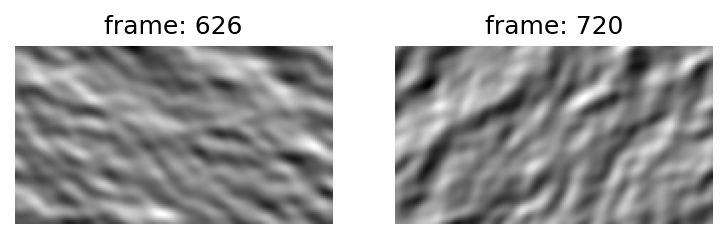

In [35]:
fig, axs = plt.subplots(1, 2, dpi=150) # view first and last frame of movie slice
axs[0].imshow(stimulus_trial_slice[:,:,0], cmap='gray')
axs[0].set_title(f'frame: {start}')
axs[1].imshow(stimulus_trial_slice[:,:,-1], cmap='gray')
axs[1].set_title(f'frame: {end}')
[ax.axis('off') for ax in axs];

### Stimulus from AWS bucket 

The stimulus can also be downloaded from the AWS bucket directly. The stimuli stored on AWS are at 30Hz.

In [36]:
import requests
import skvideo.io

In [37]:
base_url = 'https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/functional_data/stimulus_movies'

In [38]:
filename = f'stimulus_17797_{scan_key["session"]}_{scan_key["scan_idx"]}_v1.avi'

In [39]:
url = base_url + '/' + filename
url

'https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/functional_data/stimulus_movies/stimulus_17797_4_7_v1.avi'

In [40]:
# movie_aws = requests.get(url) # uncomment this cell to download movie. each movie is approx 2GB movie

# with open(filename, 'wb') as f:
#     f.write(movie_aws.content) # will write to current directory as avi

### Pupil and Treadmill

The pupil radius for each scan is found in `nda.RawManualPupil` and `nda.ManualPupil`. 

`pupil_min_r` is the smaller of the two radii from the ellipse fit to the pupil and `pupil_maj_r` is the larger radius. 

The tracked position of the pupil is found in `pupil_x` and `pupil_y`. 

`nda.RawManualPupil` contains the pupil traces and `pupil_times` at the original acquisition rate.

`nda.ManualPupil` contains the pupil traces synced to the `field 1` scan times (found in the `field1_times` attribute in `nda.DepthTimes`)



In [41]:
nda.RawManualPupil() & scan_key

*session    *scan_idx    pupil_min_ pupil_maj_ pupil_x    pupil_y    pupil_time
+---------+ +----------+ +--------+ +--------+ +--------+ +--------+ +--------+
4           7            =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=    
 (Total: 1)

In [42]:
nda.ManualPupil & scan_key

*session    *scan_idx    pupil_min_ pupil_maj_ pupil_x    pupil_y   
+---------+ +----------+ +--------+ +--------+ +--------+ +--------+
4           7            =BLOB=     =BLOB=     =BLOB=     =BLOB=    
 (Total: 1)

The treadmill velocity for each scan is found in `nda.RawTreadmill` and `nda.Treadmill`.

`nda.RawTreadmill` contains the treadmill velocity trace and timestamps at the original acquisition rate.

`nda.Treadmill` contains the treadmill velocity trace synced to the `field 1` scan times (found in the `field1_times` attribute in `nda.DepthTimes`)

In [43]:
nda.RawTreadmill & scan_key

*session    *scan_idx    treadmill_ treadmill_
+---------+ +----------+ +--------+ +--------+
4           7            =BLOB=     =BLOB=    
 (Total: 1)

In [44]:
nda.Treadmill & scan_key

*session    *scan_idx    treadmill_
+---------+ +----------+ +--------+
4           7            =BLOB=    
 (Total: 1)

### Summary image

A summary image of the field can be found in `nda.SummaryImages`. 

There are two types of images available, `correlation` and `average`. Details of how these are computed can be found in the accompanying methods.

In [45]:
nda.SummaryImages & field_key

*session    *scan_idx    *field    correlatio average   
+---------+ +----------+ +-------+ +--------+ +--------+
4           7            4         =BLOB=     =BLOB=    
 (Total: 1)

#### Fetch and view images

In [46]:
corr, avg = (nda.SummaryImages & field_key).fetch1('correlation', 'average')

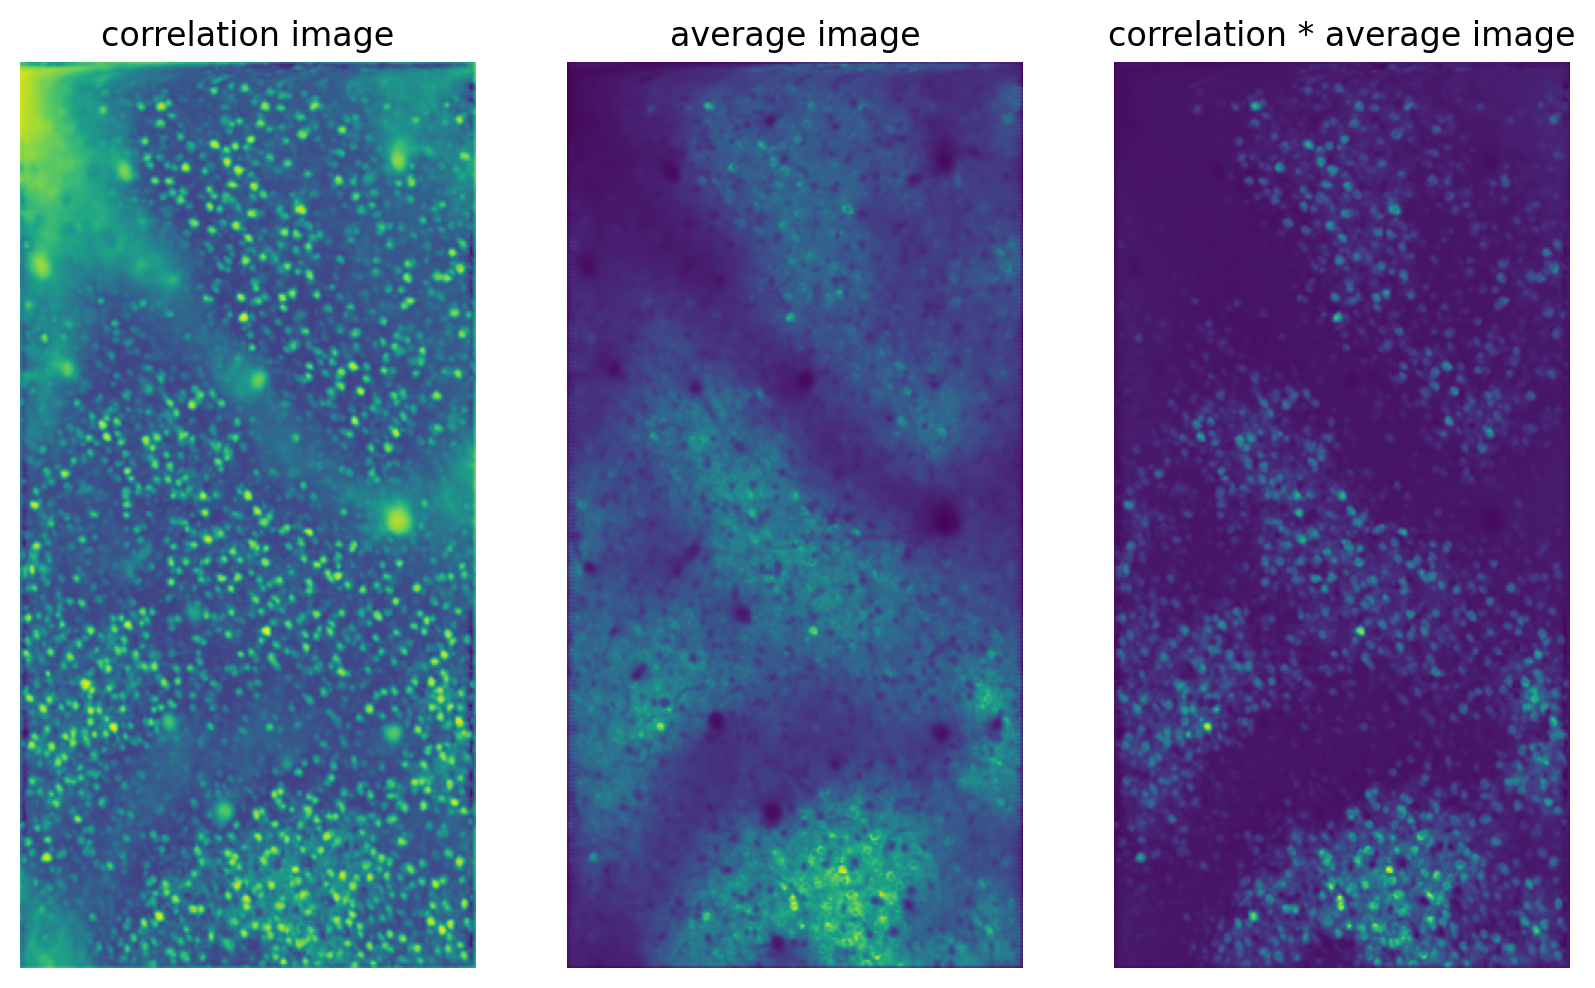

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(10,6), dpi=200)
axs[0].imshow(corr)
axs[0].set_title('correlation image')
axs[1].imshow(avg)
axs[1].set_title('average image')
axs[2].imshow(corr*avg) # gives a good view of the cell bodies and darkens vessels
axs[2].set_title('correlation * average image')
[ax.axis('off') for ax in axs];
[ax.set_aspect('auto') for ax in axs];

### Mean Intensity

The mean intensity of the calcium signal for the entire field is computed per frame for the duration of the scan. This is found in `nda.MeanIntensity`. Periods of low intensity may indicate a low quality stretch of scan, for example where water might have temporarily run out between the microscope objective and imaging site.

In [48]:
intensities = (nda.MeanIntensity & field_key).fetch1('intensities')

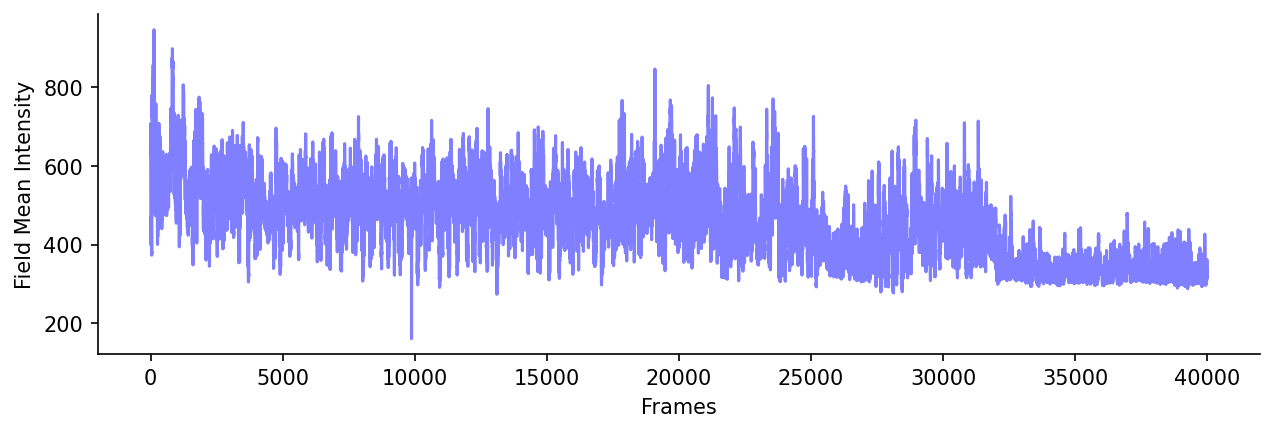

In [49]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(intensities, c='b', alpha=0.5)
ax.set_xlabel('Frames')
ax.set_ylabel('Field Mean Intensity')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Masks

The functional ROI segmentation gives a set of 2D masks indexed by `mask_id`, which are unique per `field`. A cell that was scanned in more than one imaging field will have more than one mask. Masks are stored in `nda.Segmentation`. Classification of masks as `soma` or `artifact` is stored in `nda.MaskClassification`. See technical documentation for further details on segmentation and classification methods.

In [50]:
nda.Segmentation * nda.MaskClassification & field_key

*session    *scan_idx    *field    *mask_id    pixels     weights    mask_type    
+---------+ +----------+ +-------+ +---------+ +--------+ +--------+ +-----------+
4           7            4         1           =BLOB=     =BLOB=     artifact     
4           7            4         2           =BLOB=     =BLOB=     soma         
4           7            4         3           =BLOB=     =BLOB=     soma         
4           7            4         4           =BLOB=     =BLOB=     artifact     
4           7            4         5           =BLOB=     =BLOB=     soma         
4           7            4         6           =BLOB=     =BLOB=     soma         
4           7            4         7           =BLOB=     =BLOB=     soma         
4           7            4         8           =BLOB=     =BLOB=     soma         
4           7            4         9           =BLOB=     =BLOB=     artifact     
4           7            4         10          =BLOB=     =BLOB=     artifact     
4           7            4         11          =BLOB=     =BLOB=     artifact     
4           7            4         12          =BLOB=     =BLOB=     soma         
   ...
 (Total: 1389)

Fetch masks and plot over the summary image to view them. 

*Note: the image below is intended to show the density and location of masks, but to better visualize the shape and weights of individual masks, plot them one at a time. A visualization to this effect will be added in a future iteration of this tutorial.*

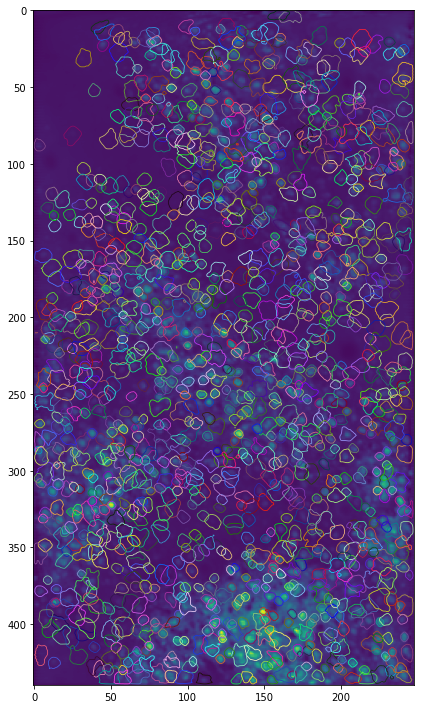

In [51]:
masks = func.get_all_masks(field_key, mask_type='soma', plot=True) # function that will retrieve masks in convenient format and optionally plot

### Calcium fluorescence traces

Each mask has a GCaMP6 fluorescence trace in `nda.Fluorescence`.

In [52]:
calcium_trace = (nda.Fluorescence() & field_key & {'mask_id': 500}).fetch1('trace')

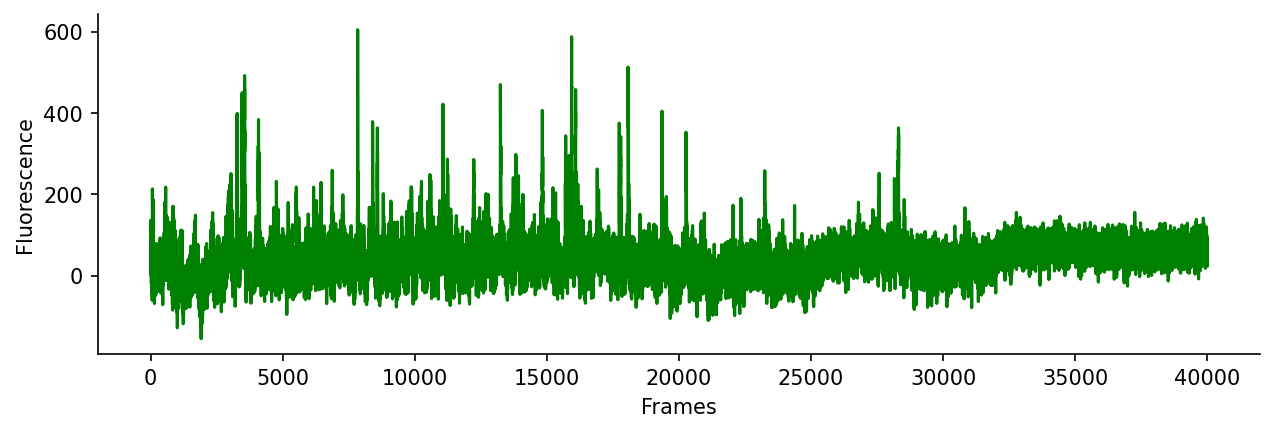

In [53]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(calcium_trace, c='g')
ax.set_xlabel('Frames')
ax.set_ylabel('Fluorescence')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Single unit information

For the purposes of this schema, a `unit` is a re-indexing of all masks across all imaging fields of a scan and indexed by `unit_id`. `unit_id` is unique per scan.

Note: `unit_id` is not a consolidation step, only re-indexing. Therefore, if a cell was scanned in multiple imaging fields within the scan, just as it had multiple `mask_id's`, it will also have multiple `unit_id's`. 

Information for all units in the scan can be found in `nda.ScanUnit`. This table can be used to relate `mask_id` to its `unit_id`.  

In [54]:
# unit coordinates (`um_x`, `um_y`, `um_z`) are in microns and in the original motor reference frame (see technical documentation for more info)
# unit coordinate (`px_x` and `px_y` are the unit coordinates in image pixels)
# this table can also be used to relate `unit_id's` and `mask_id's` that are used in nda.Segmentation and nda.Fluorescence
nda.ScanUnit() & scan_key

*session    *scan_idx    *unit_id    field     mask_id     um_x     um_y     um_z     px_x     px_y     ms_delay    
+---------+ +----------+ +---------+ +-------+ +---------+ +------+ +------+ +------+ +------+ +------+ +----------+
4           7            1           1         1           -778     -771     80       7        5        0           
4           7            2           1         2           -741     -766     80       22       7        0           
4           7            3           1         3           -691     -776     80       41       3        0           
4           7            4           1         4           -691     -766     80       42       8        0           
4           7            5           1         5           -702     -767     80       37       7        0           
4           7            6           1         6           -646     -764     80       60       8        0           
4           7            7           1         7           -553     -770     80       97       6        0           
4           7            8           1         8           -534     -758     80       105      11       0           
4           7            9           1         9           -499     -760     80       119      10       0           
4           7            10          1         10          -460     -768     80       134      7        0           
4           7            11          1         11          -362     -772     80       173      5        0           
4           7            12          1         12          -442     -675     80       141      44       2           
   ...
 (Total: 8395)

### Oracle score 

The oracle score is a leave-one-out correlation for repeated segments of stimulus. It provides an estimate of visual response reliability for a given unit over the course of the scan. For more detail see the technical documentation found [here](https://www.microns-explorer.org/cortical-mm3#f-data).

Oracle scores are found in `nda.Oracle`. 

*Note that only masks classified as "soma" in `nda.MaskClassification` currently have oracle scores computed. This may change in a future version.*

In [55]:
oracles = (nda.Oracle & scan_key).fetch('pearson')

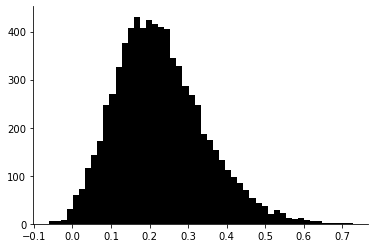

In [56]:
fig, ax = plt.subplots()
ax.hist(oracles, bins=50, color='k');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [57]:
high_oracle_percentile = np.percentile(oracles, 99)

Oracle scores greater than a threshold value can be specified by restricting the table with a string: `'pearson>x'` where `x` is the oracle value threshold.

In [58]:
high_oracle_table = nda.Oracle & scan_key & f'pearson>{high_oracle_percentile}'
high_oracle_table

*session    *scan_idx    *unit_id    trials     pearson     
+---------+ +----------+ +---------+ +--------+ +----------+
4           7            130         60         0.623745    
4           7            327         60         0.61131     
4           7            493         60         0.54457     
4           7            688         60         0.561252    
4           7            756         60         0.617953    
4           7            775         60         0.638734    
4           7            795         60         0.613519    
4           7            907         60         0.574646    
4           7            1070        60         0.553697    
4           7            1177        60         0.57389     
4           7            1262        60         0.594857    
4           7            1552        60         0.593425    
   ...
 (Total: 75)

Select the nth entry in the table by passing an `offset` and `limit` to the `fetch` method.

In [59]:
unit_key = high_oracle_table.fetch('KEY', offset=10, limit=1)[0]
unit_key

{'session': 4, 'scan_idx': 7, 'unit_id': 1262}

### Plot oracle raster

The function `fetch_oracle_raster` provided in the `func` module retrieves the responses for the functional unit for the repeated stimulus trials (oracle trials).

In [60]:
oracle_traces, score = func.fetch_oracle_raster(unit_key)

Text(0.5, 1.2, 'session: 4, scan_idx: 7, unit_id: 1262')

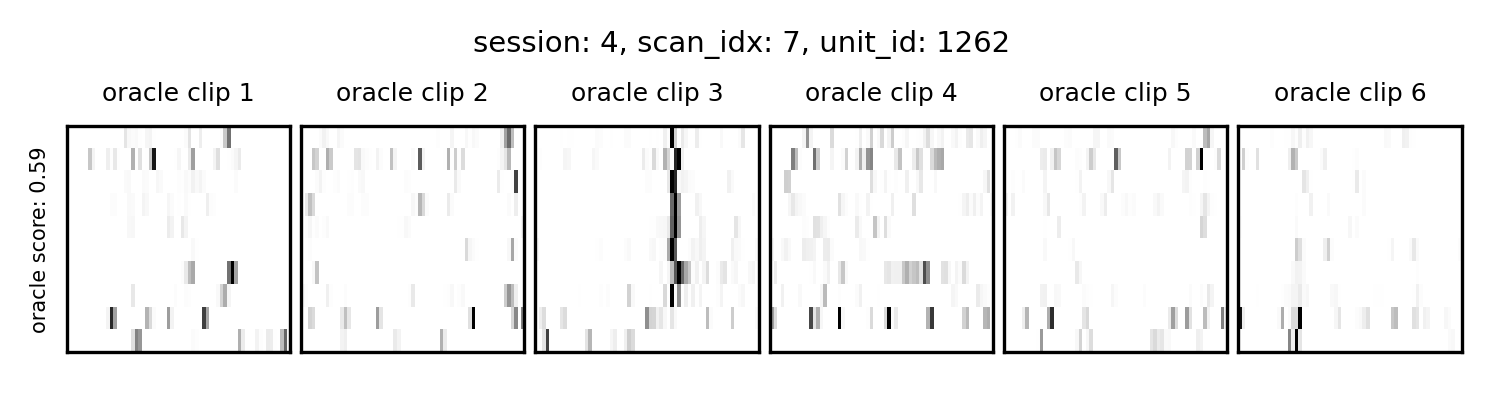

In [61]:
fig,axes = plt.subplots(1,6, figsize=(6,1),dpi=300)
for col,clip_trace in zip(axes,np.moveaxis(oracle_traces,1,0)):
    col.imshow(clip_trace,cmap='binary', interpolation='nearest')
    col.set_aspect('auto')
    col.set_xticks([])
    col.set_yticks([])
axes[0].set_ylabel(f'oracle score: {score:.2f}', fontsize=5)
fig.subplots_adjust(wspace=.05)
[ax.set_title(f'oracle clip {i+1}', fontsize=6) for i, ax in enumerate(axes)];
fig.suptitle(f'session: {unit_key["session"]}, scan_idx: {unit_key["scan_idx"]}, unit_id: {unit_key["unit_id"]}', fontsize=7, y=1.2)

### Area membership

Computed area membership labels are found in `nda.AreaMembership`.

In [62]:
nda.AreaMembership()

*session    *scan_idx    *unit_id    brain_area    
+---------+ +----------+ +---------+ +------------+
4           7            1           LM            
4           7            2           LM            
4           7            3           LM            
4           7            4           LM            
4           7            5           LM            
4           7            6           LM            
4           7            7           LM            
4           7            8           LM            
4           7            9           LM            
4           7            10          LM            
4           7            11          LM            
4           7            12          LM            
   ...
 (Total: 168971)

### Spike traces

Spike traces are in `nda.Activity` and associated with single units (`unit_id's`).

In [63]:
nda.Activity() & unit_key

*session    *scan_idx    *unit_id    trace     
+---------+ +----------+ +---------+ +--------+
4           7            1262        =BLOB=    
 (Total: 1)

In [64]:
spike_trace = (nda.Activity() & unit_key).fetch1('trace')

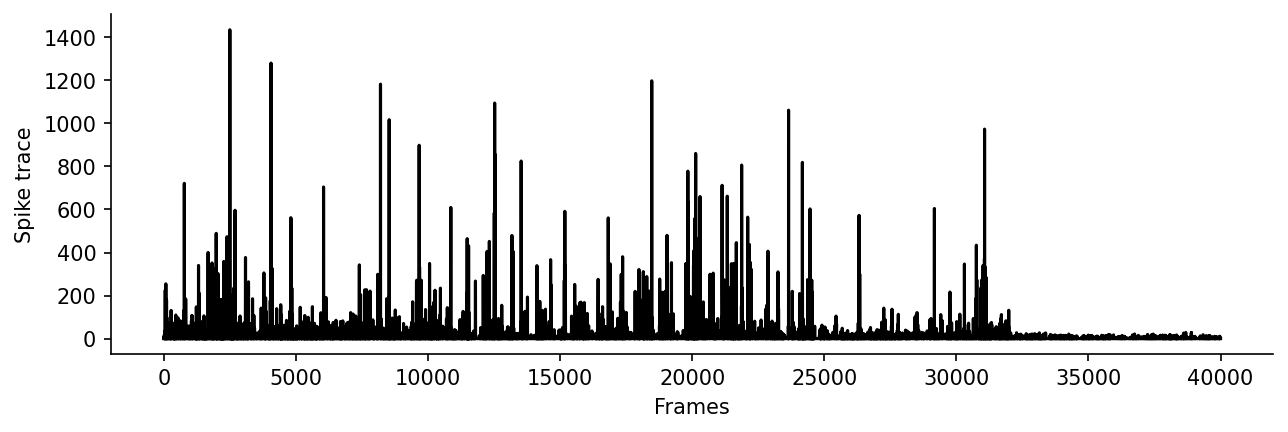

In [65]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(spike_trace, c='k')
ax.set_xlabel('Frames')
ax.set_ylabel('Spike trace')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### View  fluorescence trace, and spike trace for the same unit

Use `nda.ScanUnit` to bridge between `unit_id` and `mask_id` to plot both the calcium trace spike trace and for a single unit.

In [66]:
nda.Fluorescence & (nda.ScanUnit & unit_key)

*session    *scan_idx    *field    *mask_id    trace     
+---------+ +----------+ +-------+ +---------+ +--------+
4           7            3         167         =BLOB=    
 (Total: 1)

In [67]:
calcium_trace = (nda.Fluorescence & (nda.ScanUnit & unit_key)).fetch1('trace')

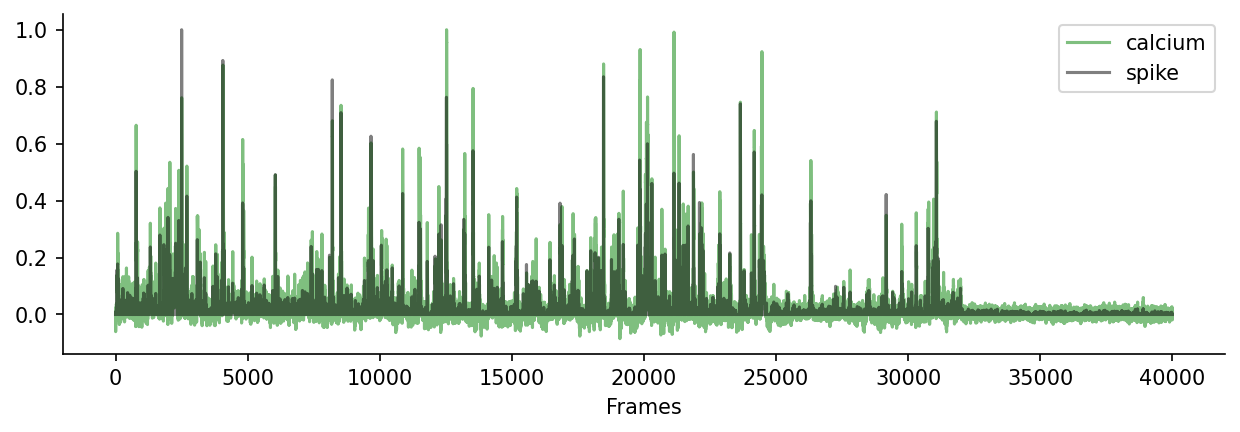

In [68]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(calcium_trace/ np.max(calcium_trace), c='g', alpha=0.5, label='calcium')
ax.plot(spike_trace/ np.max(spike_trace), c='k', label='spike', alpha=0.5)
ax.set_xlabel('Frames')
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Field to Stack registration

A high spatial resolution structural 2P-Stack was acquired to serve as a common reference frame between the 2P functional imaging planes and the EM volume. Each imaging field was registered into the stack using affine registration learned via gradient ascent. For more detail see technical methods. 

### Stack information

The information on the structural 2P stack can be found in `nda.Stack`. `motor_x`, `motor_y`, `motor_z` store the center of the stack in the original acquisition coordinates. 

In [69]:
nda.Stack()

*stack_session *stack_idx    motor_z     motor_y      motor_x     px_depth     px_height     px_width     um_depth     um_height     um_width     surf_z    
+------------+ +-----------+ +---------+ +----------+ +---------+ +----------+ +-----------+ +----------+ +----------+ +-----------+ +----------+ +--------+
9              19            314.0       -173.688     -236.91     335          661           706          670.0        1322.0        1412.0       -21.0     
 (Total: 1)

The affine matrix resulting from registration of each imaging field into the stack is located in `nda.Registration`. The attribute `reg_field` is the extracted stack image corresponding to the field grid after registration. In a good registration, the functional summary image in `nda.SummaryImages` and `reg_field` will be very similar. 

### Field registration

In [70]:
# affine matrix parameters for each field registered into the stack
nda.Registration & field_key

*stack_session *stack_idx    *session    *scan_idx    *field    a11         a21            a31           a12            a22          a32            reg_x       reg_y        reg_z       score        reg_field 
+------------+ +-----------+ +---------+ +----------+ +-------+ +---------+ +------------+ +-----------+ +------------+ +----------+ +------------+ +---------+ +----------+ +---------+ +----------+ +--------+
9              19            4           7            4         1.00784     -0.00337667    -0.017749     -0.0231734     0.994399     0.00351191     94.7115     -276.434     217.736     0.646221     =BLOB=    
 (Total: 1)

In [71]:
reg_field = (nda.Registration & field_key).fetch1('reg_field')

The functional summary image and registered stack field image are plotted for visual comparison. 

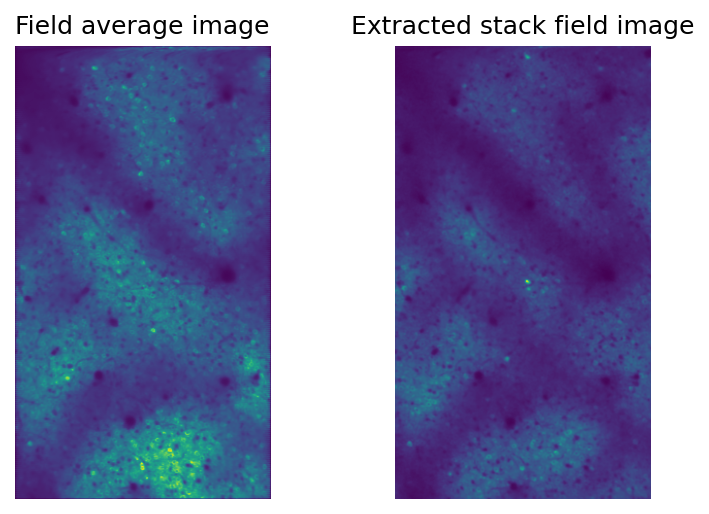

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(6,4), dpi=150)
axs[0].imshow(avg)
axs[0].set_title('Field average image')
axs[1].imshow(reg_field)
axs[1].set_title('Extracted stack field image')
[ax.axis('off') for ax in axs];

### Field grid after registration into 2P stack

The coordinates of the imaging field after registration into the 2P stack can be obtained using the function `get_grid`.  

The grid that is returned is in the original reference frame of the 2P stack, inherited from the acquisition software, called `motor` reference frame. 

In [73]:
grid = func.get_grid(field_key) # fetch registered grid in motor reference frame at 1um/ pixel resolution
grid.shape

(1100, 620, 3)

We can use the known center and dimensions of the 2P stack to convert the grid reference frame to one where the (0, 0, 0) coordinate is in the back left corner of the 3D volume. 

We refer to this as the `stack` reference frame. This conversion is necessary to be able to further convert from 2P to EM coordinate systems. 

In [74]:
center_x, center_y, center_z = nda.Stack.fetch1('motor_x', 'motor_y', 'motor_z') # get stack center in um
length_x, length_y, length_z = nda.Stack.fetch1('um_width', 'um_height', 'um_depth') # get stack dimensions in um

np_grid = grid - np.array([center_x, center_y, center_z]) + np.array([length_x, length_y, length_z]) / 2 # convert grid to the stack reference frame

np_grid.shape

(1100, 620, 3)

### Convert field grid to EM coordinates

We can use the coregistration provided by AIBS to convert between 2P Stack and EM reference frames. The source of the coregistration is [here](https://github.com/AllenInstitute/em_coregistration/tree/phase3).

We have ingested a copy of the transform solution into DataJoint and provided helper functions to facilitate it's use. The transform arguments and solution are located in `nda.Coregistration`. 

There are two versions under the `version` attribute. The correct version to use is `phase3` as `phase2` is deprecated and may be removed in the future.

There are two transform types: `spline` and `linear`. `spline` is recommended as it is the most accurate solution. It does take longer to run than `linear`, which can be used when speed is preferred over precision. Note: `linear` is not strictly a linear transformation, but the solution is more rigid than `spline` and may be preferred over `spline` in some regions of the volume, where `spline` may yield non-linear distortions.

Each direction of the transformation is solved independently and may slightly differ. `2PEM` is the 2P to EM direction, meaning 2P coordinates are provided and EM coordinates are returned. Vice versa for `EM2P`.

The attribute `transform_id` indexes the different available transforms. Taking into account the information above, only transform_id's `5-8` corresponding to `phase3` should be used. transform_id's: `5 & 6` are `spline` and 2P to EM, EM to 2P direction respectively. `7 & 8` are `linear` and 2P to EM, EM to 2P direction respectively. 

In [75]:
nda.Coregistration()

*stack_session *stack_idx    *transform_id  version     direction     transform_type transform_ transform_
+------------+ +-----------+ +------------+ +---------+ +-----------+ +------------+ +--------+ +--------+
9              19            1              phase2      2PEM          spline         =BLOB=     =BLOB=    
9              19            2              phase2      EM2P          spline         =BLOB=     =BLOB=    
9              19            3              phase2      2PEM          linear         =BLOB=     =BLOB=    
9              19            4              phase2      EM2P          linear         =BLOB=     =BLOB=    
9              19            5              phase3      2PEM          spline         =BLOB=     =BLOB=    
9              19            6              phase3      EM2P          spline         =BLOB=     =BLOB=    
9              19            7              phase3      2PEM          linear         =BLOB=     =BLOB=    
9              19            8              phase3      EM2P          linear         =BLOB=     =BLOB=    
 (Total: 8)

The function `fetch_coreg` and `coreg_transform` are available to facilitate the use of the coregistration. To use `fetch_coreg`, pass in the desired `transform_id` and the parameters of the transform will be returned.

In [76]:
transform_params = func.fetch_coreg(transform_id=5) # phase3 "spline" 2P -> #EM transform

Now we can pass the array of 3D coordinates we wish to transform and the transform parameters to `coreg_transform`. We will transform the 2P field grid obtained above to EM coordinates. 

*Note below the grid is subsampled because of memory constraints*

In [77]:
reshaped_grid = np_grid.reshape(-1, 3) # reshape grid to n X 3

em_grid = func.coreg_transform(reshaped_grid[::200], **transform_params) # pass in array of coordinates and transform parameters

In [78]:
em_grid.shape

(3410, 3)

Note: we can bypass the use of `fetch_coreg` by passing `transform_id` directly to `coreg_transform`. This may be preferable when performing a single transformation. However, when looping through multiple transformations, for efficiency it is recommended to run `fetch_coreg` first outside of the loop and pass the `transform_params` to `coreg_transform` inside the loop.

### Visualize field grid in EM coordinates in Neuroglancer

We can use [Neuroglancer](github.com/google/neuroglancer) to view the grid in EM space. 

Programmatic editing of Neuroglancer links can be accomplished using the Seung lab/ AIBS package [nglui](https://github.com/seung-lab/NeuroglancerAnnotationUI) in conjunction with CAVE.

CAVE (Connectome Annotation Versioning Engine) is built and supported by a collaboration between the Seung lab at Princeton and the Allen Institute for Brain Science. It allows for programmatic access to the tables associated with Minnie and other datasets. [Github](https://github.com/seung-lab/CAVEclient) 

CAVE setup instructions are [here](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/CAVEsetup.ipynb).

CAVE tutorial for querying the data is [here](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/SynapseAndAnnotationQuery.ipynb).

In [79]:
import pandas as pd
from caveclient import CAVEclient
from nglui import statebuilder # generate links in Seung lab a custom Neuroglancer deployment called Neuromancer

In [80]:
# this is the datastack name of the public release
# passing it will auto-configure many of the services
client = CAVEclient('minnie65_public_v117')

We need to load the grid into a pandas dataframe with a single column containing 3D point location.

In [81]:
grid_df = pd.DataFrame([[[e[0],e[1],e[2]]] for e in em_grid]).rename(columns={0:'grid_xyz'}) # sample every 200th grid point for viewing in Neuroglancer

Now we are ready to generate a Neuroglancer link to view the grid in EM space.

In [82]:
em_layer = statebuilder.ImageLayerConfig(client.info.image_source()) # public em source
seg_layer = statebuilder.SegmentationLayerConfig(client.info.segmentation_source(), name='seg') # public segmentation source
anno_layer = statebuilder.AnnotationLayerConfig(name='field-grid', mapping_rules=statebuilder.PointMapper('grid_xyz'), color='red') # annotation layer for grid 

view_kws = {'layout': '3d',
            'zoom_3d': 18000}

sb = statebuilder.StateBuilder([em_layer, seg_layer, anno_layer], view_kws=view_kws)
sb.render_state(grid_df, return_as='html')

### Transform cell coordinates from stack to EM coordinates

We can also transform the centroids of functional units to EM coordinates. The functional unit centroids in 2P stack coordinates are found in `nda.StackUnit`. 

`motor_x`, `motor_y`, `motor_z` represent the default motor reference frame inherited from the acquisition system.

`stack_x`, `stack_y`, `stack_z` represent the adjusted reference frame where (0,0,0) is located in the top, back, left corner of the volume. This adjustment is necessary to convert to EM coordinates

In [83]:
nda.StackUnit() & field_key

*stack_session *stack_idx    *session    *scan_idx    *field    *unit_id    motor_x      motor_y      motor_z     stack_x     stack_y     stack_z    
+------------+ +-----------+ +---------+ +----------+ +-------+ +---------+ +----------+ +----------+ +---------+ +---------+ +---------+ +---------+
9              19            4           7            4         2551        -168.584     -816.214     220.685     774.33      18.47       241.69     
9              19            4           7            4         2552        -98.5568     -794.077     219.522     844.35      40.61       240.52     
9              19            4           7            4         2553        -10.5446     -786.914     217.995     932.37      47.77       239.0      
9              19            4           7            4         2554        29.4794      -774.619     217.329     972.39      60.07       238.33     
9              19            4           7            4         2555        60.0042      -787.15      216.753     1002.91     47.54       237.75     
9              19            4           7            4         2556        100.434      -792.257     216.025     1043.34     42.43       237.03     
9              19            4           7            4         2557        112.974      -789.814     215.812     1055.88     44.87       236.81     
9              19            4           7            4         2558        138.112      -787.412     215.377     1081.02     47.28       236.38     
9              19            4           7            4         2559        151.0        -799.884     215.111     1093.91     34.8        236.11     
9              19            4           7            4         2560        131.306      -819.705     215.396     1074.22     14.98       236.4      
9              19            4           7            4         2561        176.543      -814.885     214.615     1119.45     19.8        235.61     
9              19            4           7            4         2562        180.945      -787.556     214.623     1123.86     47.13       235.62     
   ...
 (Total: 1389)

Fetch `stack_x`, `stack_y`, `stack_z` and format as an `n x 3` coordinate array.

In [84]:
unit_xyz_2P = np.stack((nda.StackUnit() & field_key).fetch('stack_x', 'stack_y', 'stack_z'), -1)

In [85]:
unit_xyz_2P.shape

(1389, 3)

Convert the 2P coordinates to EM coordinates and format as a pandas dataframe.

In [86]:
unit_xyz_em = func.coreg_transform(unit_xyz_2P, transform_id=5)

In [87]:
unit_xyz_em_df = pd.DataFrame([[[e[0],e[1],e[2]]] for e in unit_xyz_em]).rename(columns={0:'unit_xyz_em'})

View in Neuroglancer.

In [88]:
em_layer = statebuilder.ImageLayerConfig(client.info.image_source()) # public em source
seg_layer = statebuilder.SegmentationLayerConfig(client.info.segmentation_source(), name='seg') # public segmentation source
anno_layer = statebuilder.AnnotationLayerConfig(name='field-units', mapping_rules=statebuilder.PointMapper('unit_xyz_em'), color='red') # annotation layer for grid 

view_kws = {'layout': '3d',
            'zoom_3d': 18000}

sb = statebuilder.StateBuilder([em_layer, seg_layer, anno_layer], view_kws=view_kws)
sb.render_state(unit_xyz_em_df, return_as='html')

## Visualize area labels in 2P stack space

View area labels for units in 2D space (x, y) in `stack` reference frame.

In [89]:
area, x, y = (nda.AreaMembership * nda.StackUnit).fetch('brain_area', 'stack_x', 'stack_y')

In [90]:
color_dict = {'LM':'blue', 'AL': 'green', 'RL': 'purple', 'V1': 'red'}

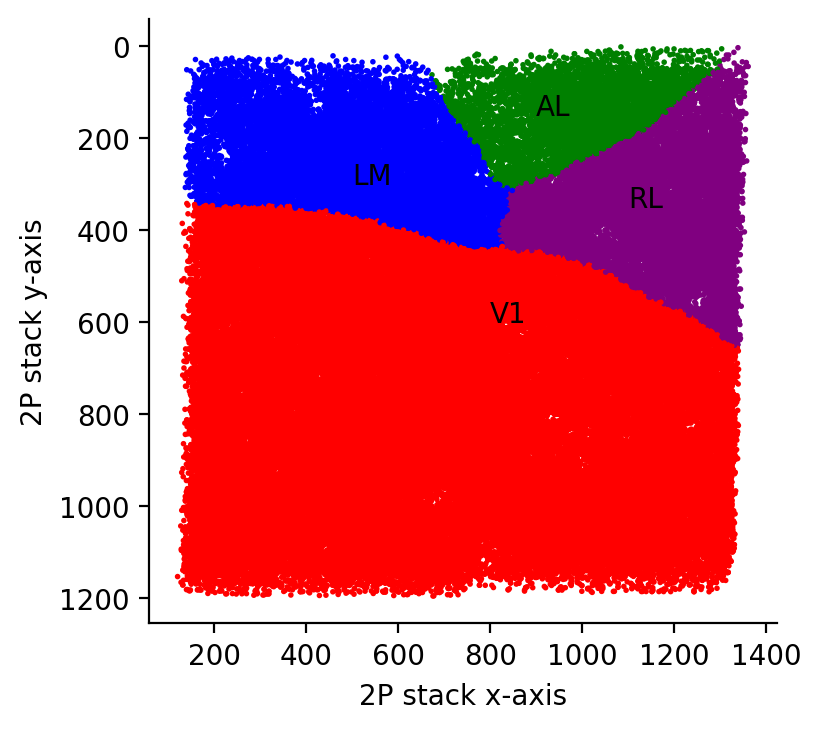

In [91]:
fig, ax = plt.subplots(dpi=200)
ax.scatter(x, y, color=[color_dict[a] for a in area], s=1)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_xlabel('2P stack x-axis')
ax.set_ylabel('2P stack y-axis')
ax.annotate('LM', (500, 300))
ax.annotate('AL', (900, 150))
ax.annotate('RL', (1100, 350))
ax.annotate('V1', (800, 600))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)